In [1]:
%matplotlib inline
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick
import pandas as pd
import glob
import seaborn as sns
import itertools
import ciso8601
import time
import sys
import warnings
import sklearn.metrics
from scipy.stats import hmean,bootstrap
from matplotlib.ticker import FuncFormatter
tqdm.tqdm.pandas()
print(sns.__version__)

import matplotlib.font_manager as font_manager
matplotlib.rc('font', **{'family' : ['Source Sans 3','sans-serif']})
font_dirs = ['/cluster/work/grlab/projects/metagenome/fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

0.13.0


In [2]:
platforms = {
    'illumina': "Illumina",
    'hifi': "PacBio HiFi",
    'clr': "PacBio CLR",
    'ont': "ONT"
}

scale_factor=1.5
mpl_rc = {
    # 'text.usetex':True,
    # 'mathtext.fontset':'stix',
    'font.family':["Source Sans 3",'sans-serif'],
    'figure.dpi':200,
    'legend.frameon': False,
    'legend.fontsize':8*scale_factor,
    'legend.title_fontsize':10*scale_factor,
    'xtick.labelsize':10*scale_factor,
    'ytick.labelsize':10*scale_factor,
    'axes.labelsize':12*scale_factor,
    'pdf.fonttype':42,
    'savefig.pad_inches':0,
    'savefig.bbox':"tight",
}
palette_rc = {
}
seaborn_rc = {
    'font.family':["Source Sans 3",'sans-serif'],
}

kept_levels = {
    "no rank": ("No Rank",11),
    "root": ("Root",10),
    "superkingdom": ("Superkingdom",9),
    "phylum": ("Phylum",8),
    "class": ("Class",7),
    "order": ("Order",6),
    "family": ("Family",5),
    "genus": ("Genus",4),
    "species": ("Species",3),
    "strain": ("Strain",2),
    "acc": ("Accession",1)
}

hue_order = [
    "GraphAligner",
    "PLAST",
    "SCA",
    "SCA+LC",
    "SCA+LC+NC",
]
hue_order_supp = [
    "GraphAligner",
    "PLAST",
    "SCA",
    "SCA+LC100",
    "SCA+LC",
    "SCA+LC+NC",
]

colors = [
    "#fb8072",
    "#fdb462",
    "#f0027f",
    "#8dd3c7",
    "#666666", 
    "#80b1d3",
]

palette = dict(zip(hue_order_supp,colors))

kept_levels_list = list(kept_levels.values())[::-1]

def parse_elapsed(line):
    line = line.rstrip()
    if line.find(".") == -1:
        line = line + ".00"
    elapsed = line.split(" ")[-1].split(":")
    if len(elapsed) < 3:
        elapsed = ["00"] * (3 - len(elapsed)) + elapsed
        
    ndays = 0
    if int(elapsed[0]) > 23:
        ndays,hrs = divmod(int(elapsed[0]),24)
        elapsed[0] = str(hrs)
    elapsed = ":".join(t.rjust(2, '0') for t in elapsed)
    start_dtime = ciso8601.parse_datetime(f'2023-11-13 00:00:00')
    total_dtime = ciso8601.parse_datetime(f'2023-11-13 {elapsed}')
    return (total_dtime - start_dtime).total_seconds() + 24*3600*ndays
    
print(parse_elapsed("Elapsed (wall clock) time (h:mm:ss or m:ss): 2:08.70"))
print(parse_elapsed("Elapsed (wall clock) time (h:mm:ss or m:ss): 26:25:24"))

128.7
95124.0


In [3]:
branch_lengths = (1/(np.arange(len(kept_levels)-2)+1))[::-1]
mid_branch_lengths = (1/(np.arange(len(kept_levels)-2)+0.5))[::-1]

branch_lengths_cum = branch_lengths.cumsum() * 2
mid_branch_lengths_cum = mid_branch_lengths.cumsum() * 2

total_branch_length = branch_lengths_cum[-1]

display(total_branch_length,
        branch_lengths,
        branch_lengths_cum/total_branch_length,
        mid_branch_lengths)
print()

midpoints = [0]
minpoints = []
print(list(kept_levels.keys())[-1],1-midpoints[-1],midpoints[-1])
for unifrac,mid_unifrac,level in zip(branch_lengths_cum,
                                     mid_branch_lengths_cum,
                                     list(kept_levels.keys())[::-1][1:]):
    midpoints.append(unifrac/total_branch_length)
    minpoints.append(mid_unifrac/total_branch_length)
    print(level,
          1.0 - midpoints[-1],
          1.0 - minpoints[-1])
midpoints = np.array(midpoints)
minpoints = np.array(minpoints)

acc_midpoints = (1.0-midpoints)[::-1]
acc_minpoints = (1-minpoints)[::-1]
print(acc_minpoints)

5.657936507936508

array([0.11111111, 0.125     , 0.14285714, 0.16666667, 0.2       ,
       0.25      , 0.33333333, 0.5       , 1.        ])

array([0.0392762 , 0.08346192, 0.13395988, 0.19287418, 0.26357133,
       0.35194277, 0.46977136, 0.64651424, 1.        ])

array([0.11764706, 0.13333333, 0.15384615, 0.18181818, 0.22222222,
       0.28571429, 0.4       , 0.66666667, 2.        ])


acc 1 0
strain 0.9607238041801094 0.9584134397201158
species 0.9165380838827325 0.9112820047362471
genus 0.8660401178285875 0.8568995797548602
family 0.8071258240987516 0.7926294411404937
order 0.7364286716229484 0.7140770495007126
class 0.6480572310281947 0.6130811173924225
phylum 0.5302286435685231 0.47168681244081645
superkingdom 0.3534857623790153 0.23602963752147288
root 0.0 -0.4709418872365576
[-0.47094189  0.23602964  0.47168681  0.61308112  0.71407705  0.79262944
  0.85689958  0.911282    0.95841344]


In [4]:
sample_ids = []
ncomps = []
with open('../graph_props/components.txt', 'r') as f:
    for line in f:
        line = line.rstrip().split()
        ncomps.append(int(line[-3]))
        sample_ids.append(".".join(line[0].split(".")[:2]))
sample_ids_to_comp = pd.DataFrame({
    "sample_id":sample_ids,
    "Number of components in graph":ncomps,
})
display(sample_ids_to_comp)

,sample_id,Number of components in graph
0,AB568599.1,65
1,AB568600.1,58
2,AE016821.1,70
3,AF275271.2,116
4,AF285261.1,63
...,...,...
3037,OQ506664.1,561
3038,OQ538214.1,286
3039,OQ538215.1,398
3040,OQ581157.1,47


In [679]:
in_files = glob.glob("*/*.sweep.tsv")
assert(len(in_files))
nseeds = 0.01


tables = []
for file in in_files:
    fsplit = file.split("/")[-1].split(".")
    platform = platforms[fsplit[0]]
    infile = f'{fsplit[0]}.tiny.fa'
    if fsplit[-4] == "tsv":
        if fsplit[-5] == "mla":
            cur_nseeds = float(".".join(fsplit[-7:-5]))
            if cur_nseeds != nseeds:
                continue
            method = "SCA+LC+NC"
            logfile = f'{infile}.{nseeds}.mla.log'
            alnfile = f'{infile}.{nseeds}.mla.tsv'
        elif fsplit[-5] == "mlahap":
            cur_nseeds = float(".".join(fsplit[-7:-5]))
            if cur_nseeds != nseeds:
                continue
            method = "SCA+LC100"
            logfile = f'{infile}.{nseeds}.mlahap.log'
            alnfile = f'{infile}.{nseeds}.mlahap.tsv'
        elif fsplit[-5] == "mlahap10":
            continue
        elif fsplit[-5] == "mlalt":
            cur_nseeds = float(".".join(fsplit[-7:-5]))
            if cur_nseeds != nseeds:
                continue
            method = "SCA+LC"
            logfile = f'{infile}.{nseeds}.mlalt.log'
            alnfile = f'{infile}.{nseeds}.mlalt.tsv'
        else:
            cur_nseeds = float(".".join(fsplit[-6:-4]))
            if cur_nseeds != nseeds:
                continue
            method = "SCA"
            logfile = f'{infile}.{nseeds}.log'
    elif fsplit[-4] == "gaf":
        method = "GraphAligner"
        logfile = f'../ga_jointgraph/{infile}.log'
    elif fsplit[-4] == "out":
        assert(fsplit[-5] == "plast")
        method = "PLAST"
        logfile = f'../plast_aln/{infile}.plast.log'
    with open(file, 'r') as f,open(logfile, 'r') as g:
        table = pd.read_table(f, header=None, names=["read_id","accID","true_taxid","header","class_taxid","classification"])
        table["Method"] = method
        table["Platform"] = platform
        if method in ["GraphAligner","PLAST"]:
            g_iter = (line for line in g if line.find("Elapsed")!=-1 or line.find("Maximum resident set size") != -1)
            dtime = parse_elapsed(next(g_iter))
            maxrss = int(next(g_iter).rstrip().split()[-1])
            table["Time (s)"] = dtime/len(table)
            table["RAM Usage"] = maxrss/len(table)
        elif method in ["SCA+LC+NC","SCA+LC100","SCA+LC"]:
            mla_start = 0
            mla_end = 0
            chain_time = []
            ext_time = []
            mla_time = []
            num_label_changes = []
            with open(alnfile, 'r') as h:
                for line in h:
                    line = line.rstrip().split()
                    if line[2] == "*":
                        num_label_changes.append(0)
                        continue
                    orientation,target,score,nmatches,cigar,offset,labels = line[2:9]
                    labels = labels.split(">")
                    if len(labels) == 1:
                        num_label_changes.append(0)
                        continue
                    labels_parse = (a.split(":")[0] for a in labels)
                    num_label_changes.append(len([a for a in labels_parse if len(a)]))
                    
            for line in g:
                if line.find("throughput") != -1:
                    total_time = float(line.rstrip().split()[-2])
                    table["Time (s)"] = total_time/len(table)
                    continue
                if line.find("Maximum resident set size") != -1:
                    maxrss = int(line.rstrip().split()[-1])
                    table["RAM Usage"] = maxrss/len(table)
                    continue
                line = line.split("\t")
                if len(line) < 3:
                    first_split = line[0].split(" ")
                    if line[0][-12:] == "coordinates\n":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        aln_start = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    elif len(first_split) > 3 and first_split[3] == "Reduced":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        ext_start = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    elif len(first_split) > 4 and " ".join(first_split[3:5]) == "Chaining alignments":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        mla_start = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    elif len(first_split) > 3 and first_split[3] == "Assembled":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        mla_end = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    continue

                if line[2][:9] != "covered: ":
                    continue
                    
                dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                aln_end = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                
                assert(aln_end >= ext_start)
                if ext_start < aln_start:
                    chain_time.append(0)
                    ext_time.append(0)
                    mla_time.append(0)
                else:
                    chain_time.append(ext_start - aln_start)
                    ext_time.append(mla_start - ext_start if mla_start >= ext_start else aln_end - ext_start)
                    mla_time.append(mla_end - mla_start if mla_start >= ext_start else 0)
                aln_start = 0
                ext_start = 0
                mla_start = 0
                mla_end = 0
            table["Chaining"] = chain_time
            table["Extension"] = ext_time
            table["MLATime"] = mla_time
            table["\# Label Changes"] = num_label_changes
        elif method == "SCA":
            chain_time = []
            ext_time = []
            mla_time = []
            for line in g:
                if line.find("throughput") != -1:
                    total_time = float(line.rstrip().split()[-2])
                    table["Time (s)"] = total_time/len(table)
                    continue
                if line.find("Maximum resident set size") != -1:
                    maxrss = int(line.rstrip().split()[-1])
                    table["RAM Usage"] = maxrss/len(table)
                    continue
                line = line.split("\t")
                if len(line) < 3:
                    first_split = line[0].split(" ")
                    if line[0][-12:] == "coordinates\n":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        aln_start = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    elif len(first_split) > 3 and first_split[3] == "Reduced":
                        dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                        ext_start = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                    continue
                
                if line[2][:9] != "covered: ":
                    continue
                    
                dtime = ciso8601.parse_datetime(" ".join(line[0][1:].split(" ")[:2])[:-1])
                aln_end = time.mktime(dtime.timetuple()) + dtime.microsecond/1000000
                assert(aln_end >= ext_start)
                if ext_start < aln_start:
                    chain_time.append(0)
                    ext_time.append(0)
                else:
                    chain_time.append(ext_start - aln_start)
                    ext_time.append(aln_end - ext_start)
                mla_time.append(0)
                
                aln_start = 0
                ext_start = 0
                mla_start = 0
            table["Chaining"] = chain_time
            table["Extension"] = ext_time
            table["MLATime"] = mla_time
        else:
            assert(False)
    tables.append(table)
df = pd.concat(tables)
df["classification"] = df["classification"].transform(lambda x:x.split(";"))
df = df.explode("classification")
df["classification"] = df["classification"].transform(lambda x:x.split(","))
df = df.drop(columns=['true_taxid','class_taxid'])
df[["Total Coverage","Relative Length Cutoff","class_taxid","WGSUniFrac","BestNamedLevel","BestLevel","Relative Score"]] \
    = pd.DataFrame(df["classification"].apply(pd.Series))
df = df.drop(columns=['classification','header',"BestLevel"])
df["Rank of LCA"] = df["BestNamedLevel"].transform(lambda x:kept_levels[x][1])
df["BestNamedLevel"] = df["BestNamedLevel"].transform(lambda x:kept_levels[x][0])

df = df.astype({
   "Total Coverage":float,
   "Relative Length Cutoff":float,
   "WGSUniFrac":float,
   "Relative Score":float,
}).reset_index().drop(columns=['index'])

df["Top Relative Score"] = df.groupby(["Method","Platform","read_id"])["Relative Score"].transform('max')
df["Scaled Relative Score"] = df["Relative Score"] / df["Top Relative Score"]

df["Overhead"] = df["Time (s)"] - (df["Extension"] + np.nan_to_num(df["Chaining"] + df["MLATime"], nan=0))

df.loc[df["Method"] == "GraphAligner","WGSUniFrac"] = np.nan
df["Number of components in graph"] = df['accID'].map(sample_ids_to_comp.set_index("sample_id").squeeze())

assert(df["Relative Score"].min() == 0.0)
assert(df["Relative Score"].max() <= 1.0)

df["Method"] = pd.Categorical(df["Method"],categories=hue_order_supp)
df["Platform"] = pd.Categorical(df["Platform"],categories=platforms.values())

display(df)

nreads = df["read_id"].max() + 1
df["WGSUniFrac"].describe()

,read_id,accID,Method,Platform,Time (s),RAM Usage,Chaining,Extension,MLATime,\# Label Changes,...,Relative Length Cutoff,class_taxid,WGSUniFrac,BestNamedLevel,Relative Score,Rank of LCA,Top Relative Score,Scaled Relative Score,Overhead,Number of components in graph
0,0,CP083471.1,SCA+LC,PacBio CLR,1.659862,11277.52,0.046,2.211,0.00,0.0,...,1.000000,3095872,0.000000,Accession,0.790919,1,0.790919,1.000000,-0.597137,15
1,1,HE576754.1,SCA+LC,PacBio CLR,1.659862,11277.52,0.051,0.974,0.03,0.0,...,0.165766,1064592,0.062500,Strain,0.136680,2,0.136680,1.000000,0.604862,2968
2,1,HE576754.1,SCA+LC,PacBio CLR,1.659862,11277.52,0.051,0.974,0.03,0.0,...,0.104891,1064592,0.062500,Strain,0.084556,2,0.136680,0.618644,0.604862,2968
3,1,HE576754.1,SCA+LC,PacBio CLR,1.659862,11277.52,0.051,0.974,0.03,0.0,...,0.089060,1064592,0.062500,Strain,0.071171,2,0.136680,0.520716,0.604862,2968
4,1,HE576754.1,SCA+LC,PacBio CLR,1.659862,11277.52,0.051,0.974,0.03,0.0,...,0.085586,1064592,0.062500,Strain,0.068211,2,0.136680,0.499058,0.604862,2968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,99,HG934063.1,SCA,PacBio HiFi,2.012258,9214.48,0.016,0.261,0.00,NaN,...,0.006328,1437815,0.006578,Strain,0.006106,2,0.117020,0.052182,1.735258,10362
20058,99,HG934063.1,SCA,PacBio HiFi,2.012258,9214.48,0.016,0.261,0.00,NaN,...,0.005218,1437815,0.006578,Strain,0.005218,2,0.117020,0.044592,1.735258,10362
20059,99,HG934063.1,SCA,PacBio HiFi,2.012258,9214.48,0.016,0.261,0.00,NaN,...,0.007439,1437815,0.006578,Strain,0.003775,2,0.117020,0.032258,1.735258,10362
20060,99,HG934063.1,SCA,PacBio HiFi,2.012258,9214.48,0.016,0.261,0.00,NaN,...,0.019762,1437815,0.009374,Strain,0.003442,2,0.117020,0.029412,1.735258,10362


count    16641.000000
mean         0.140967
std          0.179926
min          0.000000
25%          0.052632
50%          0.078891
75%          0.178724
max          1.366418
Name: WGSUniFrac, dtype: float64

In [680]:
def agg_mean_std(x):
    if np.any(np.isnan(x)):
        return np.nan
    return "${:.3f}\pm{:.3f}$".format(x.mean(), x.std())

df_breakdown = df.groupby(["Platform","Method","read_id"]).apply(
    lambda x:x.iloc[0].drop(["Platform","Method","read_id"])
).reset_index().groupby(["Platform","Method"]).agg({
    "Chaining":[agg_mean_std,'sum'],
    "Extension":[agg_mean_std,'sum'],
    "MLATime":[agg_mean_std,'sum'],
    "Time (s)":'sum',
    "Overhead":[agg_mean_std,'sum'],
}).dropna()

for a in ["Chaining","Extension","MLATime",
          "Overhead"
         ]:
    df_breakdown[(a,"\%")] = df_breakdown[(a,"sum")] / df_breakdown[("Time (s)","sum")] * 100

print(df_breakdown.columns)
df_breakdown = df_breakdown[df_breakdown.columns[[
    0,9,
    2,10,
    4,11,
    8,12,
    6
]]]
print(df_breakdown.to_latex(escape=False,float_format="%.3f").replace("agg_mean_std","mean$\pm$std"))
display(df_breakdown[df_breakdown.columns[[1,3,5,7]]])

MultiIndex([( 'Chaining', 'agg_mean_std'),
            ( 'Chaining',          'sum'),
            ('Extension', 'agg_mean_std'),
            ('Extension',          'sum'),
            (  'MLATime', 'agg_mean_std'),
            (  'MLATime',          'sum'),
            ( 'Time (s)',          'sum'),
            ( 'Overhead', 'agg_mean_std'),
            ( 'Overhead',          'sum'),
            ( 'Chaining',           '\%'),
            ('Extension',           '\%'),
            (  'MLATime',           '\%'),
            ( 'Overhead',           '\%')],
           )
\begin{tabular}{lllrlrlrrrr}
\toprule
    &           & \multicolumn{2}{l}{Chaining} & \multicolumn{2}{l}{Extension} & \multicolumn{2}{l}{MLATime} & \multicolumn{2}{l}{Overhead} & Time (s) \\
    &           &     mean$\pm$std &     \% &     mean$\pm$std &     \% &     mean$\pm$std &     \% &      sum &     \% &      sum \\
Platform & Method &                  &        &                  &        &                  &       

/tmp/ipykernel_875641/3301156525.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_breakdown.to_latex(escape=False,float_format="%.3f").replace("agg_mean_std","mean$\pm$std"))


Chaining  Extension    MLATime   Overhead
                              \%         \%         \%         \%
Platform    Method                                               
Illumina    SCA        25.342225  43.070622   0.000000  31.587154
            SCA+LC100  25.649702  43.462039   0.118740  30.769519
            SCA+LC     22.861921  42.431391   0.000000  34.706687
            SCA+LC+NC  24.731820  44.804099   0.119497  30.344583
PacBio HiFi SCA        51.366667  41.020579   0.000000   7.612754
            SCA+LC100  47.448671  39.552170   5.814050   7.185109
            SCA+LC     42.225484  42.630384   6.894694   8.249438
            SCA+LC+NC  46.134103  37.789488   9.316894   6.759516
PacBio CLR  SCA        11.570539  83.998874   0.000000   4.430588
            SCA+LC100  10.948412  81.128862   3.260952   4.661773
            SCA+LC     11.014768  80.595231   4.059975   4.330026
            SCA+LC+NC  11.134893  80.000061   4.445110   4.419936
ONT         SCA        20.615802  73.745033   0.000000   5.639166
            SCA+LC100  17.877039  65.008957  12.162000   4.952004
            SCA+LC     15.780315  67.976150  10.625591   5.617944
            SCA+LC+NC  17.428353  61.673554  16.370836   4.527257

In [684]:
figwidth = 7
fontsize = 8
aspect=1.3

height = figwidth / aspect / len(platforms)

mpl_rc = {
    'font.family':['Source Sans 3'],
    'figure.dpi':200,
    'figure.figsize':(figwidth,figwidth),
    'legend.frameon': False,
    'legend.fontsize':fontsize,
    'legend.title_fontsize':fontsize,
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    'axes.labelsize':fontsize,
    'pdf.fonttype':42,
    'savefig.pad_inches':0,
    'savefig.bbox':"tight",
}

global_params = {
    "hue":"Method",
    "palette":palette,
}
facet_params = {
    "col":"Platform",
    "aspect":aspect,
    "height":height,
}
line_params = {
    "linewidth":1,
}

plot_versions = [
    (hue_order,""),
    (hue_order_supp,"_supp")
]

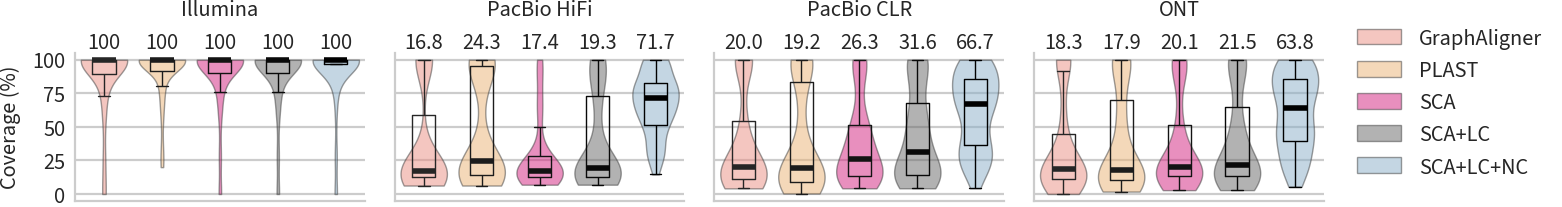

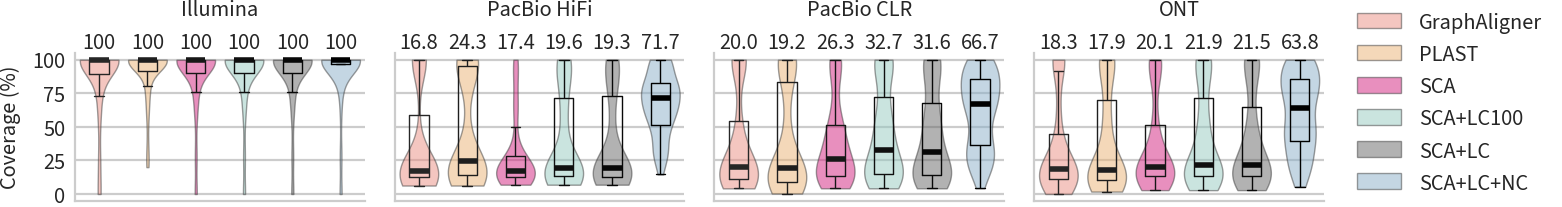

In [685]:
with matplotlib.rc_context(mpl_rc),sns.axes_style("whitegrid",rc={'font.family':['Source Sans 3'],}),sns.color_palette(**palette_rc):
    for hod,fsuff in plot_versions:
        df_agg_best = df[np.isin(df["Method"],hod)].groupby(["Platform","Method","read_id"]).agg({"Total Coverage":"min"}).rename(
            columns={"Total Coverage":"Coverage of Best Alignment"}
        ).reset_index().copy()
        df_agg_best["Method"] = pd.Categorical(df_agg_best["Method"],categories=hod)
        params = {
            "data":df_agg_best,
            "x":"Method",
            "y":"Coverage of Best Alignment",
            "linewidth":0.5,
        }
    
        g = sns.catplot(**params,
                        **global_params,
                        **facet_params,
                        kind="violin",cut=0,inner=None,
                        alpha=0.5,
                        edgecolor='black',
                        legend="full",
                        sharex=False,
                ).set_titles(col_template="{col_name}").set_xticklabels(np.arange(len(hod))).tick_params(
            top=True,labeltop=True,bottom=False,labelbottom=False,length=0,
        ).set(yticks=[0,0.25,0.5,0.75,1.0])
        
        g.map_dataframe(sns.boxplot,
                        **params,
                        **(global_params | {"palette":"dark:black"}),
                        fliersize=0,
                        fill=None,
                        width=0.4,
                        medianprops={'linewidth':2})
        df_plat_groups = df_agg_best.groupby(["Platform","Method"]).agg({params["y"]:'median'}).reset_index().groupby("Platform")
        for ax,(platform,df_plat) in zip(g.axes.flat,df_plat_groups):
            xticklabels = [
                ("{:.1f}" if platform != "Illumina" else "{:.0f}").format(
                    df_plat_meth[params["y"]].iloc[0]*100
                ) for method,df_plat_meth in df_plat.groupby("Method")
            ]
            ax.set_xticklabels(xticklabels)
            ax.tick_params(axis="x",pad=0)
        g.set_axis_labels(x_var="",y_var="Coverage (%)")
        g.legend.set_title(None)
        ax = g.axes.flat[0]
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,symbol=""))
    
        g.tight_layout()
        g.savefig(f'coverage_best{fsuff}.pdf')
        plt.show()

In [686]:
def compute_unifracs(x):
    cutoffs = sorted(x["Relative Score"].unique().tolist(),reverse=True)
    cur_found = np.zeros(nreads).astype(bool)
    cur_unifracs = np.ones(nreads) * np.nan
    cur_mask = ~np.isnan(cur_unifracs)
    
    unifracs = []
    recalls = []
    
    cur_nfound = 0

    unifracs.append(np.array([]))
    recalls.append(0.0)
    
    for cutoff in cutoffs:
        if cutoff == 0:
            break
        grouped = x[x["Relative Score"] == cutoff].groupby("read_id")
        if grouped.ngroups > 0:
            for read_id,df_r in grouped:
                cur_found[read_id] = True
                cur_unifracs[read_id] = 1-df_r["WGSUniFrac"].iloc[-1]
            cur_nfound = cur_found.sum()
            cur_mask = ~np.isnan(cur_unifracs)
            recalls.append(cur_nfound/nreads)
            unifracs.append(cur_unifracs[cur_mask])
    
    if cutoffs[-1] != 0:
        cutoffs.append(0)
    recalls.append(cur_nfound/nreads)
    unifracs.append(cur_unifracs[cur_mask])
    return list(zip(np.concatenate([[np.nan],cutoffs]),unifracs,recalls))

df_precrecall = df.groupby(["Platform","Method"]).progress_apply(compute_unifracs).rename("Recall").reset_index().explode("Recall").copy()
df_precrecall["Min. Relative Score Cutoff"] = df_precrecall["Recall"].transform(lambda x:x[0]).astype(float)
df_precrecall["UniFrac Accuracy"] = df_precrecall["Recall"].transform(lambda x:tuple(x[1].tolist()))
df_precrecall["Recall"] = df_precrecall["Recall"].transform(lambda x:x[2]).astype(float)
df_precrecall = df_precrecall.reset_index(drop=True)
display(df_precrecall)

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.05it/s]


,Platform,Method,Recall,Min. Relative Score Cutoff,UniFrac Accuracy
0,Illumina,GraphAligner,0.00,NaN,()
1,Illumina,GraphAligner,0.56,1.000000,()
2,Illumina,GraphAligner,0.68,0.980400,()
3,Illumina,GraphAligner,0.69,0.966667,()
4,Illumina,GraphAligner,0.70,0.913333,()
...,...,...,...,...,...
18935,ONT,SCA+LC+NC,1.00,0.000526,"(0.8933744960387945, 0.8114035087719297, 0.874..."
18936,ONT,SCA+LC+NC,1.00,0.000507,"(0.8933744960387945, 0.8114035087719297, 0.874..."
18937,ONT,SCA+LC+NC,1.00,0.000501,"(0.8933744960387945, 0.8114035087719297, 0.874..."
18938,ONT,SCA+LC+NC,1.00,0.000500,"(0.8933744960387945, 0.8114035087719297, 0.874..."


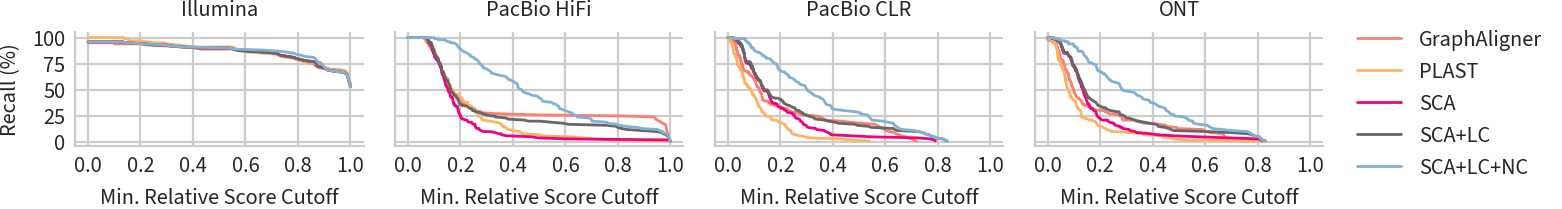

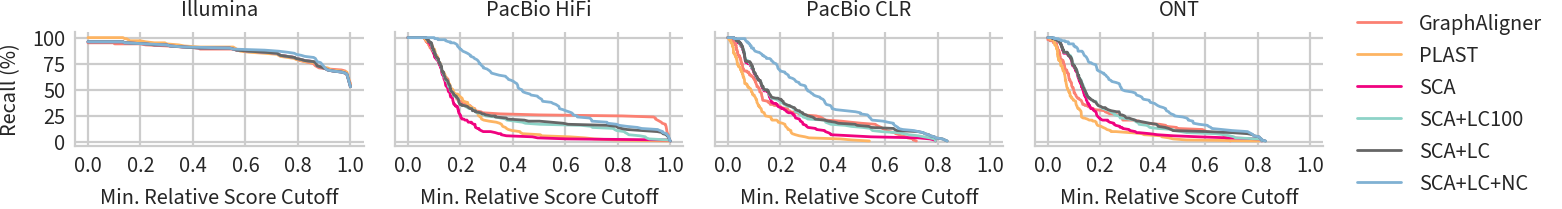

In [688]:
with matplotlib.rc_context(mpl_rc),sns.axes_style("whitegrid",rc={'font.family':['Source Sans 3'],}),sns.color_palette(**palette_rc):
    for hod,fsuff in plot_versions:
        df_plot = df_precrecall[np.isin(df_precrecall["Method"],hod)].copy()
        df_plot["Method"] = pd.Categorical(df_plot["Method"],categories=hod)
        g = sns.relplot(data=df_plot,
                        **facet_params,
                        **global_params,
                        kind="line",
                        x="Min. Relative Score Cutoff",y="Recall",
                        **line_params,
                        estimator=None,errorbar=None,
                       ).set_titles(col_template="{col_name}").set(xticks=[0,0.2,0.4,0.6,0.8,1.0],yticks=[0,0.25,0.5,0.75,1.0])
        ax = g.axes.flat[0]
        g.legend.set_title(None)
        g.set_axis_labels(y_var="Recall (%)")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,symbol=""))
        g.tick_params(pad=0)
        g.tight_layout()
        g.savefig(f'alignable{fsuff}.pdf')
        plt.show()

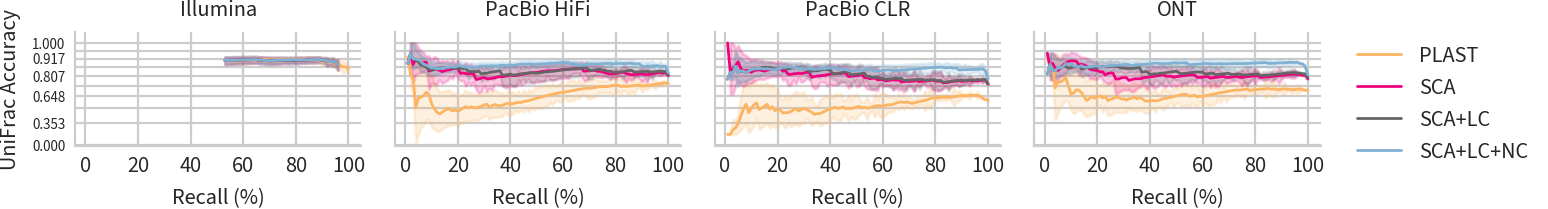

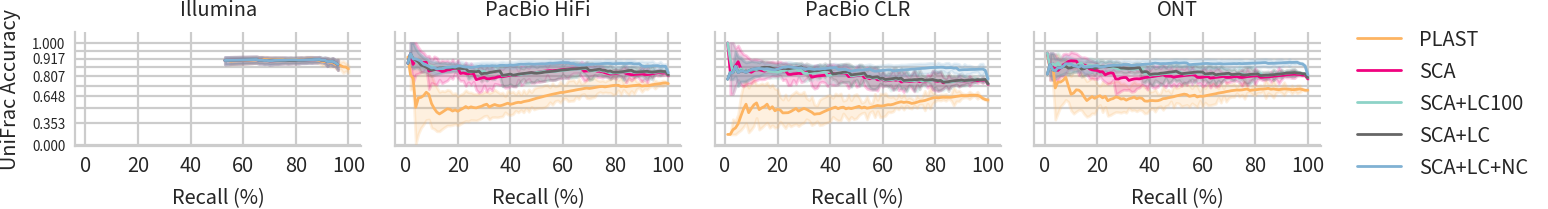

In [689]:
with matplotlib.rc_context(mpl_rc),sns.axes_style("whitegrid",rc={'font.family':['Source Sans 3'],}),sns.color_palette(**palette_rc):
    yscale_params = {
        "value":"function",
        "functions":(
            lambda x:1/((1-x)+1),
            lambda x:1-1/x+1
        )
    }

    mask = df_precrecall["Min. Relative Score Cutoff"] != 0
    for hod,fsuff in plot_versions:
        mask1 = np.isin(df_precrecall["Method"],hod[1:])
        df_plot = df_precrecall[mask & mask1].copy()
        df_plot["Method"] = pd.Categorical(df_plot["Method"],categories=hod[1:])
        g = sns.FacetGrid(data=df_plot.explode("UniFrac Accuracy").reset_index(),
                          **facet_params)
        g.map_dataframe(sns.lineplot,
                        x="Recall",
                        y="UniFrac Accuracy",
                        n_boot=1000,
                        seed=42,
                        **global_params,
                        **line_params,
                       ).set_titles(col_template="{col_name}").set(xticks=[0,0.2,0.4,0.6,0.8,1.0])
        g.add_legend(title=None)
        ax = g.axes.flat[0]
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0,symbol=""))
        ax.set_yscale(**yscale_params)
        g.set_axis_labels(x_var="Recall (%)")
        acc_midpoints = (1.0-midpoints)[::-1]
        ax.set_yticks(acc_midpoints)
        ax.set_yticklabels(["{:.3f}".format(m) if i % 2 or i == 0 else "" for i,m in enumerate(acc_midpoints)],fontsize=fontsize/3*2)
        g.tick_params(pad=0)
    
        g.tight_layout()
        g.savefig(f'unifrac_vs_alignable{fsuff}.pdf')
        plt.show()

assert(len(g.axes[0]) == len(platforms))
pl_v = []
m_v = []
vals = []
errs = []
meas = []
for platform,ax in zip(platforms.values(),g.axes[0]):
    for method,line,col in zip(hue_order_supp[1:],ax.lines,ax.collections):
        df_arc = pd.concat([
            pd.DataFrame(*line.get_data()).reset_index().set_index(0),
            pd.DataFrame(col.get_paths()[0].vertices).groupby(0).agg({1:['min','max']}),
        ],axis=1)
        tofill = np.isnan(df_arc[(1,"min")])
        df_arc[(1,"min")][tofill] = df_arc["index"][tofill]
        df_arc[(1,"max")][tofill] = df_arc["index"][tofill]
        if df_arc.index[0] != 0:
            first_row = df_arc.iloc[0]
            df_arc = pd.concat([pd.DataFrame(first_row).T,df_arc]).reset_index()
            df_arc.iloc[0] = (0, 1, 1, 1)
            df_arc = df_arc.set_index("level_0")
        pl_v.append(platform)
        m_v.append(method)
        vals.append(sklearn.metrics.auc(df_arc.index,df_arc["index"]))
        errs.append((
            sklearn.metrics.auc(df_arc.index,df_arc[(1,"min")]),
            sklearn.metrics.auc(df_arc.index,df_arc[(1,"max")]),
        ))
        meas.append("AUARC")
df_agg = pd.DataFrame({
    "Platform":pl_v,
    "Method":m_v,
    "Value":vals,
    "Error":errs,
    "Measure":meas,
})

In [690]:
df_uniq = df.groupby(["Platform","Method","read_id"]).agg({
    "RAM Usage":'max',
    "Time (s)":'max',
    "Total Coverage":'min',
}).reset_index()

df_ram = df_uniq.groupby(["Platform","Method"]).agg({
    "RAM Usage":[lambda x:x.sum()/1000000,lambda x:(None,None)]
}).reset_index()
df_ram.columns = ["Platform","Method","Value","Error"]
df_ram["Measure"] = "RAM Usage (GB)"

df_time = df_uniq.groupby(["Platform","Method"]).agg({
    "Time (s)":[
        lambda x:len(x)/x.sum(),
        lambda x:bootstrap((x,),lambda y: len(y)/y.sum(),n_resamples=1000,method='basic',random_state=42).confidence_interval
    ]
}).reset_index()
df_time.columns = ["Platform","Method","Value","Error"]
df_time["Measure"] = "reads/s"

df_cov = df_uniq.groupby(["Platform","Method"]).agg({
    "Total Coverage":[
        'mean',
        lambda x:bootstrap((x,),np.mean,n_resamples=1000,method='basic',random_state=42).confidence_interval
    ]
}).reset_index()
df_cov.columns = ["Platform","Method","Value","Error"]
df_cov["Measure"] = "Mean Coverage of Best Alignment"

df_agg = pd.concat([
    df_agg,
    df_ram[df_ram.columns],
    df_time[df_time.columns],
    df_cov[df_cov.columns],
]).reset_index(drop=True)
df_agg["Platform"] = pd.Categorical(df_agg["Platform"],categories=platforms.values())
df_agg["Method"] = pd.Categorical(df_agg["Method"],categories=hue_order_supp)
df_agg_pretty = df_agg.groupby(["Platform","Method","Measure"]).apply(
    lambda x:"{:.3f}".format(x["Value"].iloc[0]) + (" [{:.3f},{:.3f}]".format(*x["Error"].iloc[0]) if x["Error"].iloc[0][0] is not None else "")
).unstack()
display(df_agg_pretty)
print(df_agg_pretty.to_latex())

Measure                                 AUARC Mean Coverage of Best Alignment  \
Platform    Method                                                              
Illumina    GraphAligner                  NaN             0.868 [0.817,0.920]   
            PLAST         0.930 [0.915,0.943]             0.904 [0.867,0.943]   
            SCA           0.895 [0.880,0.908]             0.886 [0.842,0.933]   
            SCA+LC100     0.895 [0.880,0.908]             0.886 [0.842,0.933]   
            SCA+LC        0.895 [0.880,0.908]             0.886 [0.842,0.933]   
            SCA+LC+NC     0.895 [0.880,0.908]             0.899 [0.856,0.946]   
PacBio HiFi GraphAligner                  NaN             0.368 [0.294,0.432]   
            PLAST         0.648 [0.535,0.747]             0.451 [0.382,0.521]   
            SCA           0.835 [0.780,0.880]             0.286 [0.232,0.336]   
            SCA+LC100     0.845 [0.803,0.880]             0.395 [0.331,0.459]   
            SCA+LC        0.845 [0.803,0.882]             0.385 [0.320,0.448]   
            SCA+LC+NC     0.881 [0.856,0.904]             0.676 [0.632,0.720]   
PacBio CLR  GraphAligner                  NaN             0.373 [0.302,0.445]   
            PLAST         0.548 [0.444,0.647]             0.398 [0.328,0.473]   
            SCA           0.806 [0.747,0.857]             0.375 [0.316,0.436]   
            SCA+LC100     0.811 [0.758,0.857]             0.438 [0.373,0.503]   
            SCA+LC        0.815 [0.767,0.857]             0.429 [0.366,0.494]   
            SCA+LC+NC     0.852 [0.816,0.884]             0.614 [0.562,0.671]   
ONT         GraphAligner                  NaN             0.346 [0.276,0.411]   
            PLAST         0.677 [0.582,0.761]             0.384 [0.318,0.456]   
            SCA           0.820 [0.767,0.865]             0.362 [0.296,0.425]   
            SCA+LC100     0.840 [0.797,0.877]             0.406 [0.337,0.473]   
            SCA+LC        0.838 [0.797,0.875]             0.397 [0.331,0.464]   
            SCA+LC+NC     0.882 [0.854,0.908]             0.608 [0.555,0.662]   

Measure                  RAM Usage (GB)                    reads/s  
Platform    Method                                                  
Illumina    GraphAligner          2.281        1.090 [1.090,1.090]  
            PLAST                 3.486        0.135 [0.135,0.135]  
            SCA                   0.270  113.643 [113.643,113.643]  
            SCA+LC100             0.272  118.749 [118.749,118.749]  
            SCA+LC                0.270     91.447 [91.447,91.447]  
            SCA+LC+NC             0.269  119.478 [119.478,119.478]  
PacBio HiFi GraphAligner          2.281        1.038 [1.038,1.038]  
            PLAST                 3.963        0.001 [0.001,0.001]  
            SCA                   0.921        0.497 [0.497,0.497]  
            SCA+LC100             0.913        0.464 [0.464,0.464]  
            SCA+LC                0.920        0.393 [0.393,0.393]  
            SCA+LC+NC             0.939        0.459 [0.459,0.459]  
PacBio CLR  GraphAligner          2.281        1.039 [1.039,1.039]  
            PLAST                 3.733        0.002 [0.002,0.002]  
            SCA                   1.161        0.631 [0.631,0.631]  
            SCA+LC100             1.154        0.567 [0.567,0.567]  
            SCA+LC                1.128        0.602 [0.602,0.602]  
            SCA+LC+NC             1.130        0.567 [0.567,0.567]  
ONT         GraphAligner          2.281        1.028 [1.028,1.028]  
            PLAST                 3.790        0.002 [0.002,0.002]  
            SCA                   2.161        0.714 [0.714,0.714]  
            SCA+LC100             2.153        0.629 [0.629,0.629]  
            SCA+LC                2.169        0.480 [0.480,0.480]  
            SCA+LC+NC             2.163        0.618 [0.618,0.618]

\begin{tabular}{llllll}
\toprule
    & Measure &                AUARC & Mean Coverage of Best Alignment & RAM Usage (GB) &                    reads/s \\
Platform & Method &                      &                                 &                &                            \\
\midrule
Illumina & GraphAligner &                  NaN &             0.868 [0.817,0.920] &          2.281 &        1.090 [1.090,1.090] \\
    & PLAST &  0.930 [0.915,0.943] &             0.904 [0.867,0.943] &          3.486 &        0.135 [0.135,0.135] \\
    & SCA &  0.895 [0.880,0.908] &             0.886 [0.842,0.933] &          0.270 &  113.643 [113.643,113.643] \\
    & SCA+LC100 &  0.895 [0.880,0.908] &             0.886 [0.842,0.933] &          0.272 &  118.749 [118.749,118.749] \\
    & SCA+LC &  0.895 [0.880,0.908] &             0.886 [0.842,0.933] &          0.270 &     91.447 [91.447,91.447] \\
    & SCA+LC+NC &  0.895 [0.880,0.908] &             0.899 [0.856,0.946] &          0.269 &  119.478 [119.478

/tmp/ipykernel_875641/1234589914.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_agg_pretty.to_latex())


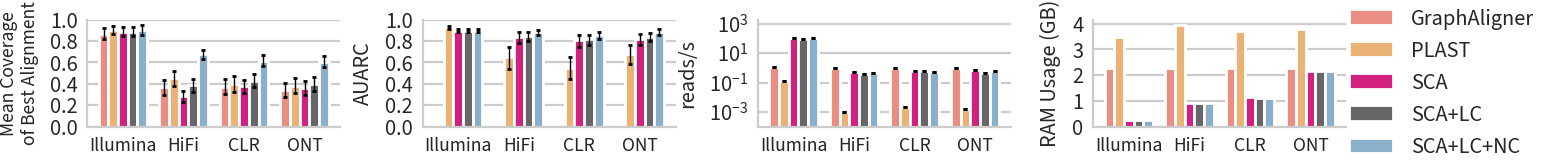

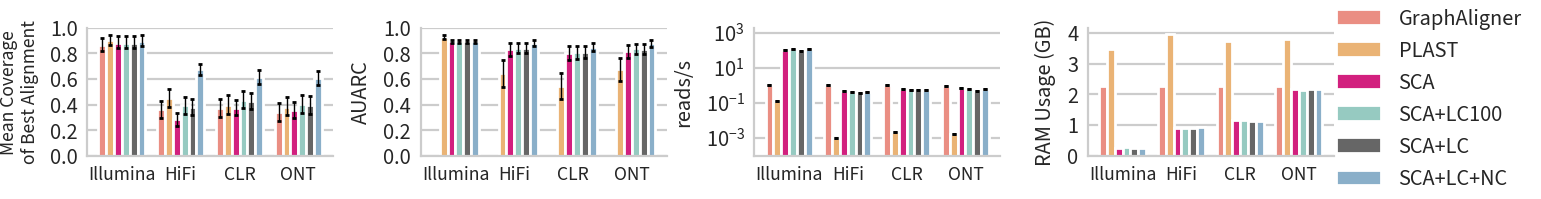

In [692]:
with matplotlib.rc_context(mpl_rc),sns.axes_style("whitegrid",rc=seaborn_rc),sns.color_palette(**palette_rc):
    col_order = [
        "Mean Coverage of Best Alignment",
        "AUARC",
        "reads/s",
        "RAM Usage (GB)"
    ]
    for hod,fsuff in plot_versions:
        df_plot = df_agg[np.isin(df_agg["Method"],hod)].copy()
        df_plot["Method"] = pd.Categorical(df_plot["Method"],categories=hod)
        cur_aspect = 1.2 if fsuff == "" else 1.1
        h = sns.catplot(data=df_plot,
                        **(facet_params | {
                            "col":"Measure",
                            "col_order":col_order,
                            "aspect":cur_aspect,
                            "height":figwidth/cur_aspect/len(col_order)
                        }),
                        **global_params,
                        kind="bar",
                        x="Platform",y="Value",
                        sharey=False,
                       )
        h.legend.set_title("")
        h.set_xlabels("")
        h.tick_params(pad=0)
        assert(len(h.axes[0]) == len(col_order))
        meas_grouped = df_plot.groupby("Measure")
        for measure,ax in zip(col_order,h.axes[0]):
            df_m = meas_grouped.get_group(measure)
            for x,(platform,df_g) in enumerate(df_m.groupby("Platform")):
                y = df_g["Value"].to_numpy()
                yerr = np.array(df_g["Error"].tolist()).T
                if yerr[0][0] is None:
                    yerr = None
                else:
                    yerr[0] = y - yerr[0]
                    yerr[1] = yerr[1] - y
                xvals = []
                for method,container in zip(hod,ax.containers):
                    if len(container) == 0:
                        continue
                    assert(len(container) == len(platforms))
                    width = container.patches[x].get_width()
                    xvals.append(container.patches[x].get_xy()[0]+container.patches[x].get_width()/2)
                ax.errorbar(xvals,
                            y=y,
                            yerr=yerr,
                            fmt='none',
                            capsize=0.75,
                            color='black',
                            linewidth=0.5,
                )
            ax.set_ylabel(measure)
            if measure == "reads/s":
                ax.set_yscale("log")
                ax.set_yticks(np.logspace(-3,3,4))
                ax.set_ylim([1e-4,2e3])
            if measure == "AUARC":
                ax.set_yticks(np.linspace(0,1,6))
            if measure == "RAM Usage (GB)":
                ax.set_yticks(np.linspace(0,4,5))
            if measure == "Mean Coverage of Best Alignment":
                ax.set_ylabel("Mean Coverage\nof Best Alignment",fontsize=7)
                ax.set_yticks(np.linspace(0,1,6))
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(
                # [a.get_text().replace(" ","\n") for a in ax.get_xticklabels()],
                # ax.get_xticklabels(),
                [a.get_text().split(" ")[-1] for a in ax.get_xticklabels()],
                # rotation=20,
                # ha='right',
                # rotation_mode='anchor',
                fontsize=7
            )
            ax.tick_params(axis="both",pad=0)
            ax.set_title("")
        # sns.move_legend(h, "lower center",title=None,ncol=len(palette),bbox_to_anchor=(.5,-0.01),fontsize=fontsize)
        h.savefig(f'compare_bar{fsuff}.pdf')
        plt.show()